
# Sprint 3 – Análise NDVI x Produtividade Agrícola

Este notebook documenta a Sprint 3 do desafio Ingredion, com foco na validação do modelo de IA comparando **NDVI médio** com **produtividade agrícola real**, com simulação por talhões.

## Etapas contempladas:
1. Coleta de dados históricos (IBGE, NDVI via Embrapa)
2. Preparação e simulação dos dados por talhão
3. Análise estatística (correlação, regressão)
4. Visualização gráfica
5. Discussão crítica


## Sobre a Simulação por Talhões

Como os dados públicos do IBGE estão disponíveis apenas em nível municipal, e imagens NDVI agregadas também têm resolução espacial limitada, optamos por **simular dados por talhão** com base na média anual real de cada variável. Essa simulação tem o objetivo de:

- Representar uma estrutura espacial mais próxima da realidade agrícola;
- Demonstrar como uma futura coleta georreferenciada permitiria análises mais precisas;
- Viabilizar testes estatísticos com granularidade por subdivisão territorial (talhão).

Cada ano foi dividido em 9 talhões simulados, com pequenas variações realistas no NDVI, produtividade e rendimento.

> **Importante**: Esses valores não representam talhões reais, mas são estatisticamente coerentes com os dados reais agregados.

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import numpy as np


In [2]:

# Carregamento dos dados simulados por talhão
df = pd.read_csv("../datasets/dados_simulados_por_talhao.csv")
df.head()


,Talhao,Ano,NDVI,Produtividade_ton,Rendimento_kg_ha
0,Talhao_1,2018,0.691,1525.6,2112.5
1,Talhao_2,2018,0.708,1745.9,2189.9
2,Talhao_3,2018,0.687,1841.1,2072.9
3,Talhao_4,2018,0.705,1417.7,2098.0
4,Talhao_5,2018,0.701,1547.5,2195.4


Dados ausentes por coluna:
Talhao               0
Ano                  0
NDVI                 0
Produtividade_ton    0
Rendimento_kg_ha     0
dtype: int64


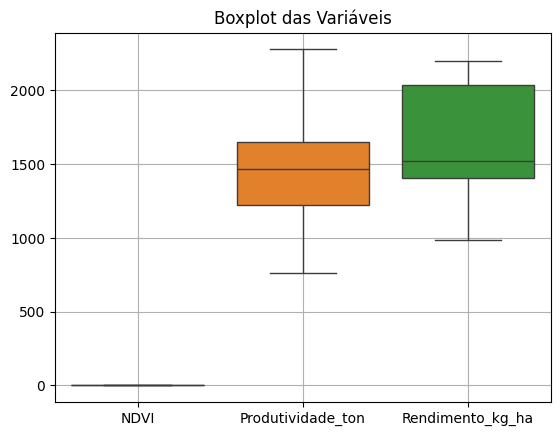

In [3]:

# Verificar dados ausentes
print("Dados ausentes por coluna:")
print(df.isnull().sum())

# Análise de outliers simples via boxplot
sns.boxplot(data=df[['NDVI', 'Produtividade_ton', 'Rendimento_kg_ha']])
plt.title("Boxplot das Variáveis")
plt.grid(True)
plt.show()


In [4]:

# Agrupar por ano para estatísticas básicas
df_grouped = df.groupby("Ano").agg({
    "NDVI": "mean",
    "Produtividade_ton": "sum",
    "Rendimento_kg_ha": "mean"
}).reset_index()

df_grouped


,Ano,NDVI,Produtividade_ton,Rendimento_kg_ha
0,2018,0.695667,14355.0,2145.277778
1,2019,0.651222,12707.9,1567.755556
2,2020,0.626444,17942.1,2066.388889
3,2021,0.588778,13569.8,1474.800000
4,2022,0.555778,8620.2,1076.122222
5,2023,0.677667,11234.5,1441.411111


In [5]:

# Correlação e regressão linear simples
X = df_grouped["NDVI"].values.reshape(-1, 1)
y = df_grouped["Produtividade_ton"].values
model = LinearRegression().fit(X, y)
df_grouped["Produtividade_Prevista"] = model.predict(X)
df_grouped["Erro"] = df_grouped["Produtividade_ton"] - df_grouped["Produtividade_Prevista"]

pearson_corr, _ = pearsonr(df_grouped["NDVI"], df_grouped["Produtividade_ton"])
spearman_corr, _ = spearmanr(df_grouped["NDVI"], df_grouped["Produtividade_ton"])
r_squared = model.score(X, y)

print("Correlação de Pearson:", round(pearson_corr, 3))
print("Correlação de Spearman:", round(spearman_corr, 3))
print("Coeficiente de Determinação R²:", round(r_squared, 3))


Correlação de Pearson: 0.338
Correlação de Spearman: 0.314
Coeficiente de Determinação R²: 0.114


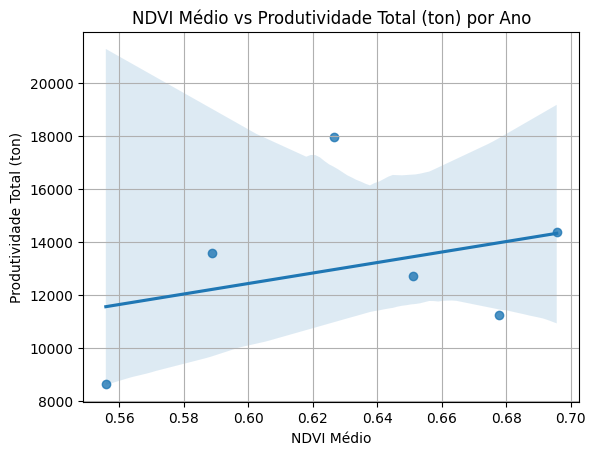

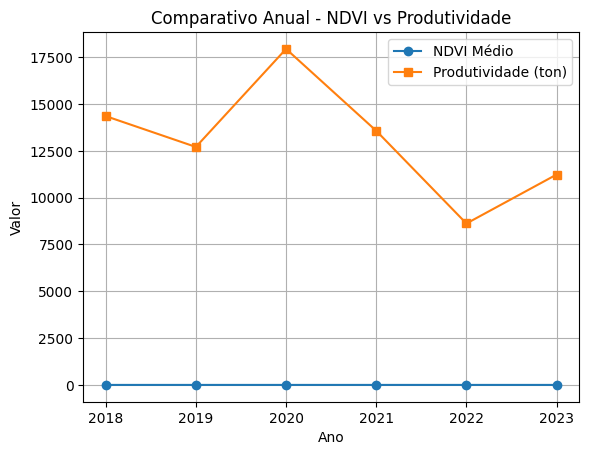

In [6]:

# Gráfico NDVI x Produtividade total
sns.regplot(x="NDVI", y="Produtividade_ton", data=df_grouped)
plt.title("NDVI Médio vs Produtividade Total (ton) por Ano")
plt.xlabel("NDVI Médio")
plt.ylabel("Produtividade Total (ton)")
plt.grid(True)
plt.show()

# Comparativo por ano
plt.plot(df_grouped["Ano"], df_grouped["NDVI"], marker='o', label="NDVI Médio")
plt.plot(df_grouped["Ano"], df_grouped["Produtividade_ton"], marker='s', label="Produtividade (ton)")
plt.title("Comparativo Anual - NDVI vs Produtividade")
plt.xlabel("Ano")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()
